# Model Performance Analysis
This notebook loads the provided CSV file, cleans the data, and generates multiple visualizations. Assumes data file is in format produced by the benchmarking code.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## Load and Inspect Data
We start by loading the uploaded CSV file and inspecting its structure.

In [98]:
# Load the dataset
file_path = "results/actioncoref_3utt_complete.csv"
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156 entries, 0 to 3155
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Model               3156 non-null   object 
 1   Split               3156 non-null   object 
 2   Epoch               3156 non-null   int64  
 3   fit_time            3156 non-null   float64
 4   pred_time           3156 non-null   float64
 5   peak_gpu_mem_fit    3156 non-null   float64
 6   peak_gpu_mem_infer  3156 non-null   float64
 7   metric_type         3156 non-null   object 
 8   precision           3156 non-null   float64
 9   recall              3156 non-null   float64
 10  f1                  3156 non-null   float64
 11  accuracy            3156 non-null   float64
 12  class_name          3156 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 320.7+ KB
None
  Model  Split  Epoch  fit_time  pred_time  peak_gpu_mem_fit  \
0   XGB  val_0      0  1.

## Data Cleaning
We will handle missing values and ensure correct data types for numerical columns.

In [99]:

# Filter rows where Model is XGB
xgb_rows = df[df['Model'] == 'XGB']

# Create expanded rows by repeating each original XGB row for epochs 0 to 9
expanded_rows = []
for _, row in xgb_rows.iterrows():
    for epoch in range(10):  # Epoch values [0,1,...,9]
        new_row = row.copy()
        new_row['Epoch'] = epoch
        expanded_rows.append(new_row)

# Convert expanded rows to DataFrame
expanded_xgb_df = pd.DataFrame(expanded_rows)

# Remove original XGB rows from the main dataframe
df_non_xgb = df[df['Model'] != 'XGB']

# Combine the non-XGB rows with the expanded XGB rows
updated_df = pd.concat([df_non_xgb, expanded_xgb_df], ignore_index=True)



In [100]:
# Check for missing values
print("Missing values per column:")
print(updated_df.isnull().sum())

# Convert numeric columns to appropriate types
numeric_cols = ['Epoch', 'fit_time', 'pred_time', 'peak_gpu_mem_fit', 'peak_gpu_mem_infer', 'precision', 'recall', 'f1', 'accuracy']
df[numeric_cols] = updated_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN in critical columns
updated_df.dropna(subset=numeric_cols, inplace=True)

print("Data cleaned. Shape:", updated_df.shape)

#Validation data
val_data = val_data = updated_df[updated_df['metric_type'] == 'val']


Missing values per column:
Model                 0
Split                 0
Epoch                 0
fit_time              0
pred_time             0
peak_gpu_mem_fit      0
peak_gpu_mem_infer    0
metric_type           0
precision             0
recall                0
f1                    0
accuracy              0
class_name            0
dtype: int64
Data cleaned. Shape: (4236, 13)


## Average Metrics by Model
We compute and visualize the average precision, recall, F1-score, and accuracy for each model.

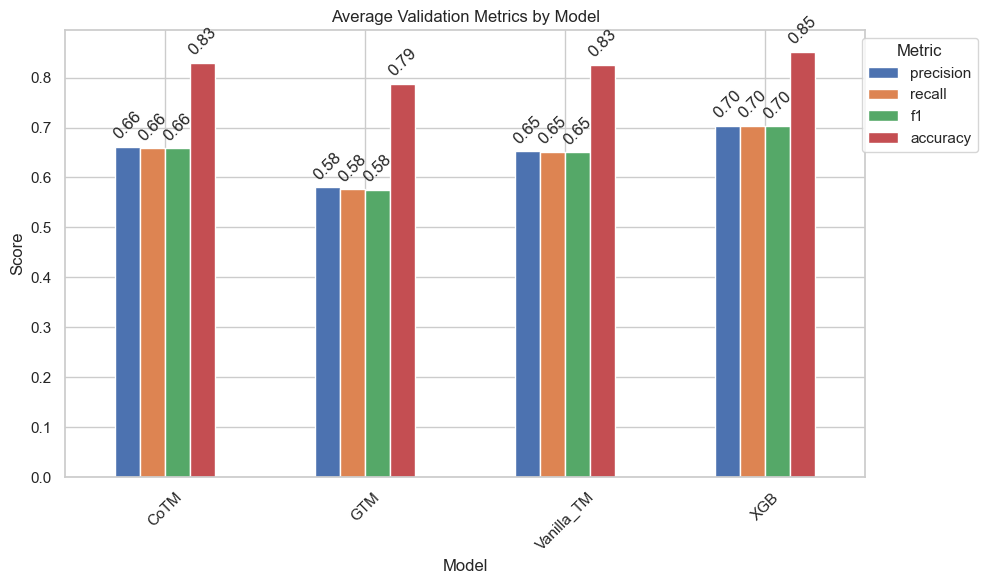

In [101]:
# Compute average metrics by model
avg_metrics = val_data.groupby('Model')[['precision', 'recall', 'f1', 'accuracy']].mean()

# Bar plot for average metrics
ax = avg_metrics.plot(kind='bar')
plt.title('Average Validation Metrics by Model')
plt.ylabel('Score')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3,  rotation=45)

plt.legend(title='Metric', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


## Line Plots Across Epochs
Visualize how metrics change across epochs for each model.

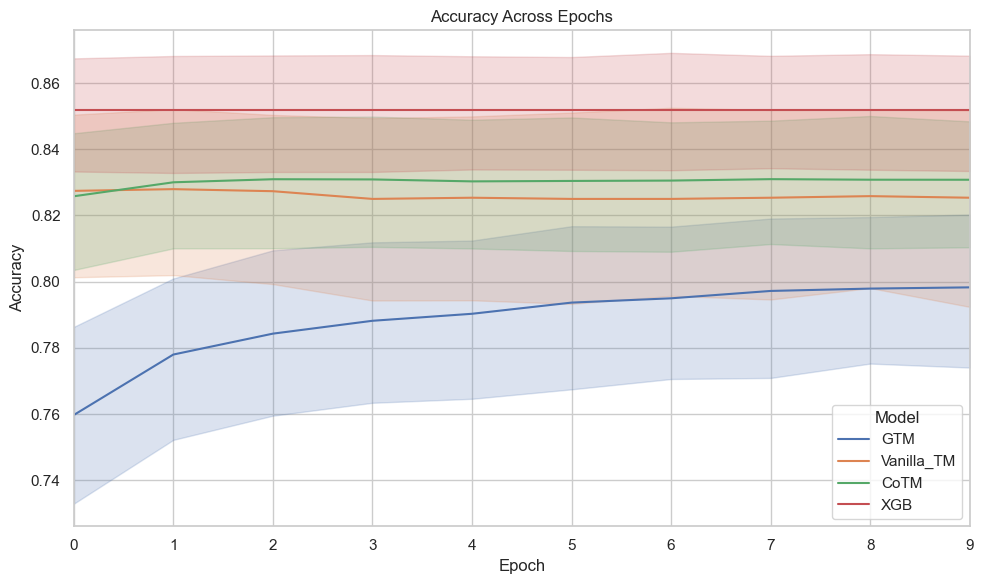

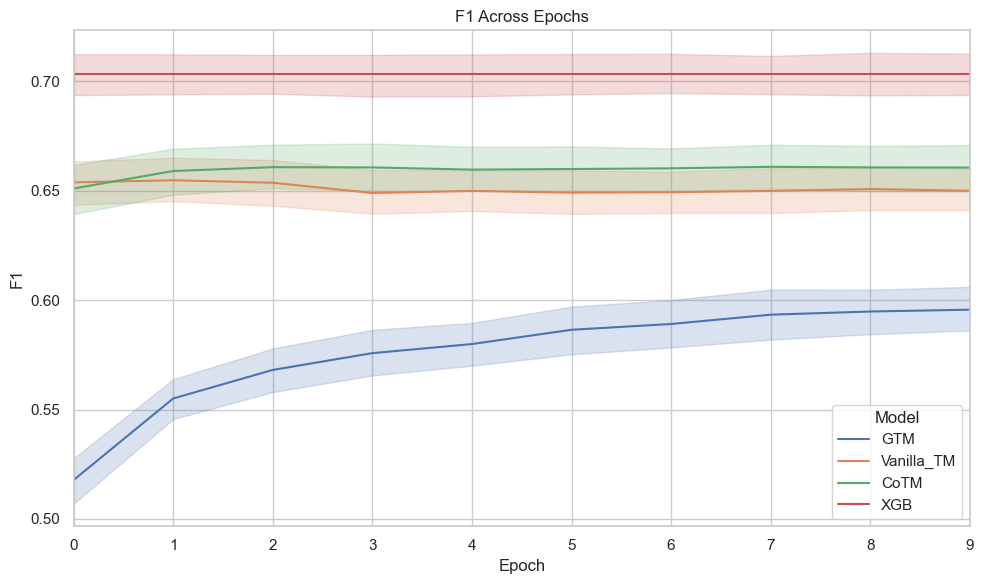

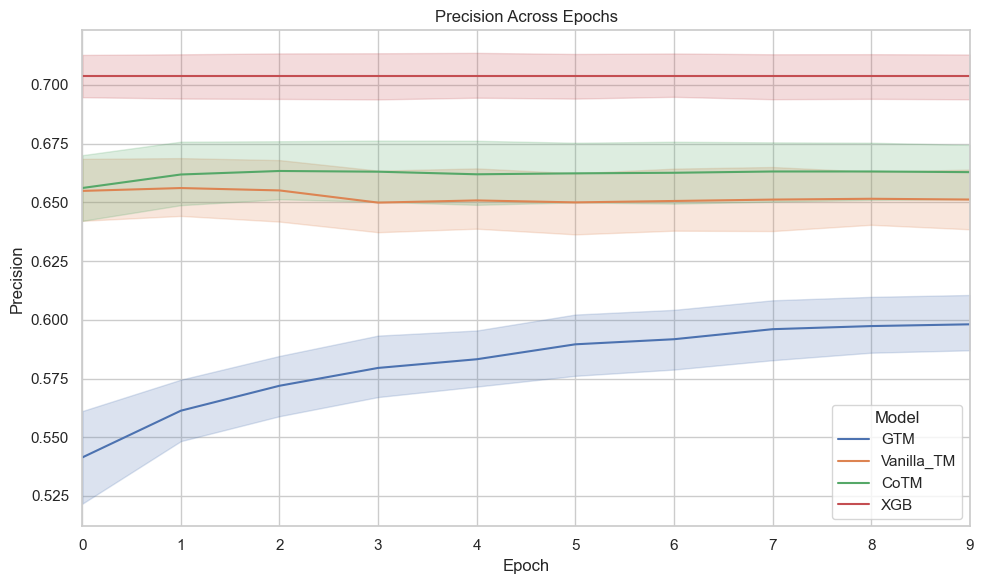

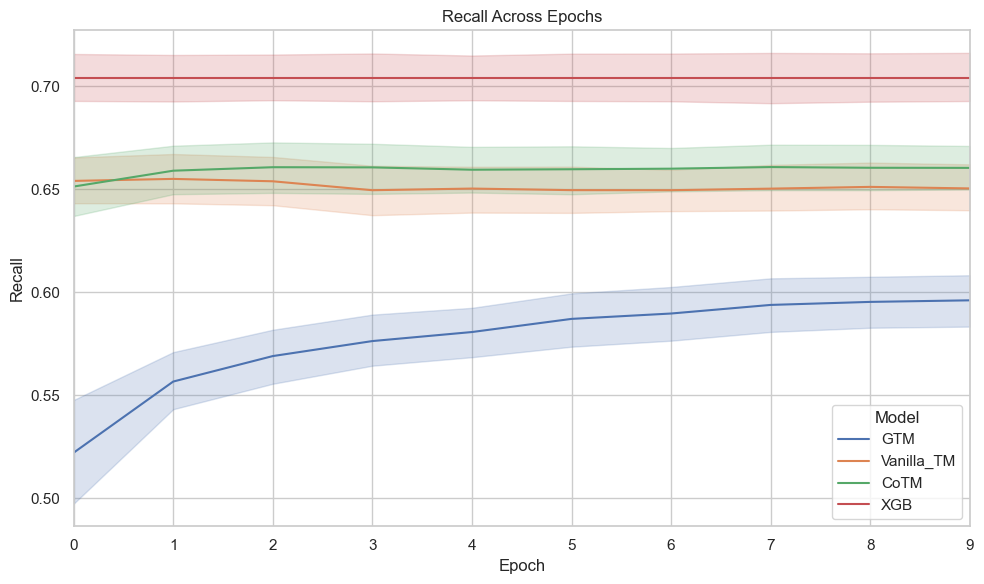

In [102]:
# Line plots for each metric
metrics = ['accuracy', 'f1', 'precision', 'recall']
for metric in metrics:
    plt.figure()
    sns.lineplot(data=val_data, x='Epoch', y=metric, hue='Model')
    plt.title(f'{metric.capitalize()} Across Epochs')
    plt.ylabel(metric.capitalize())
    plt.xlim(0, 9)
    plt.xlabel('Epoch')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()


## Boxplots for Metric Distribution
Show the distribution of metrics across models using boxplots.

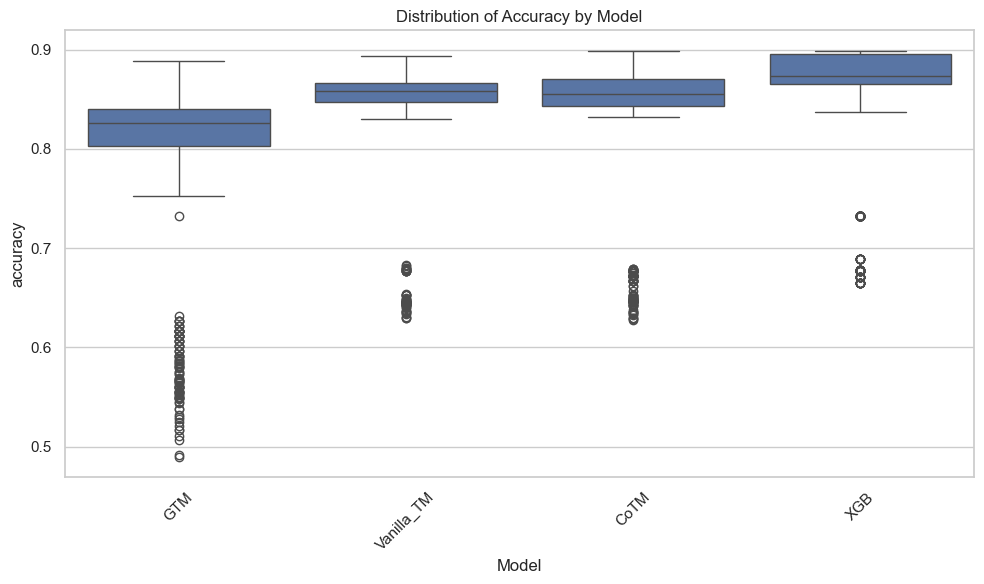

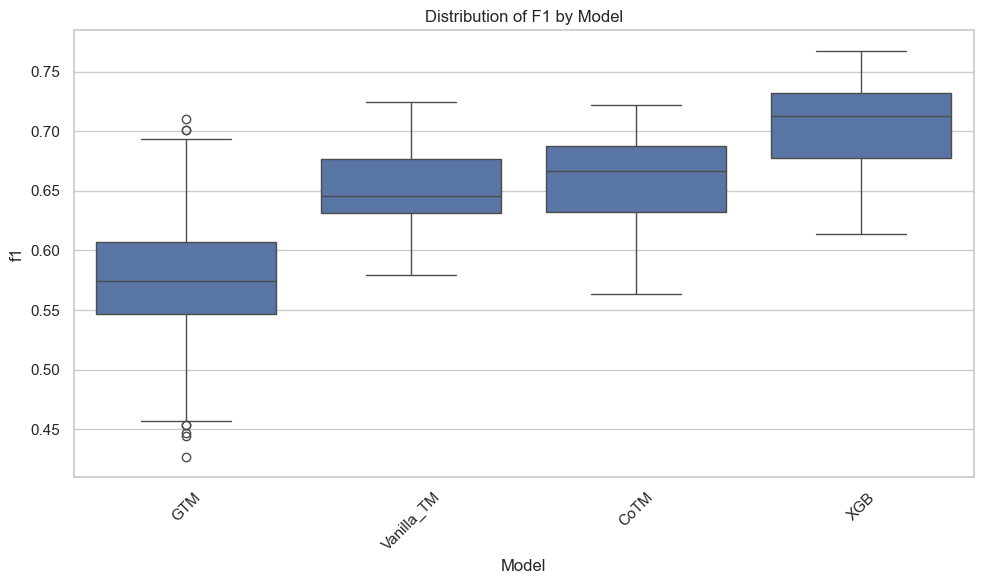

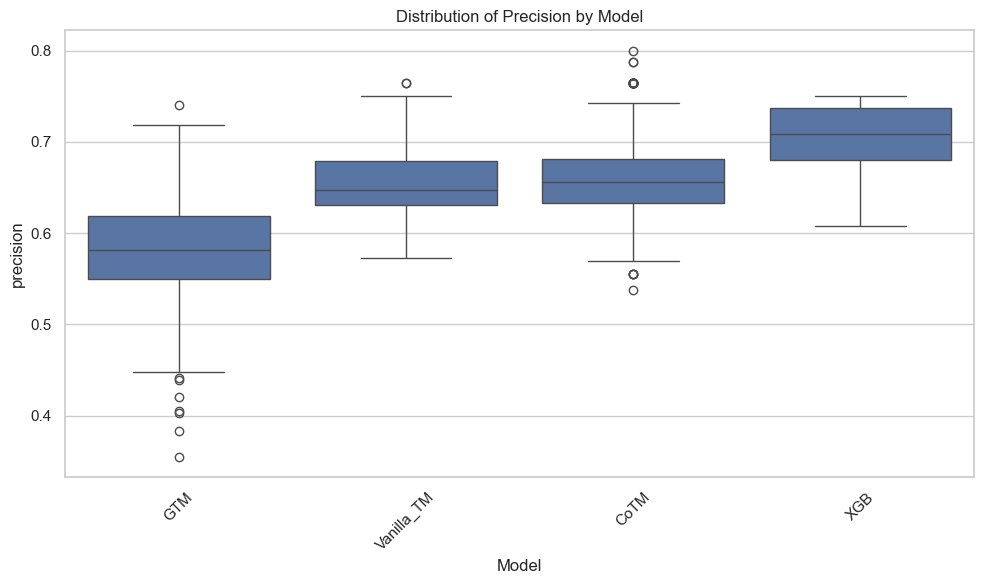

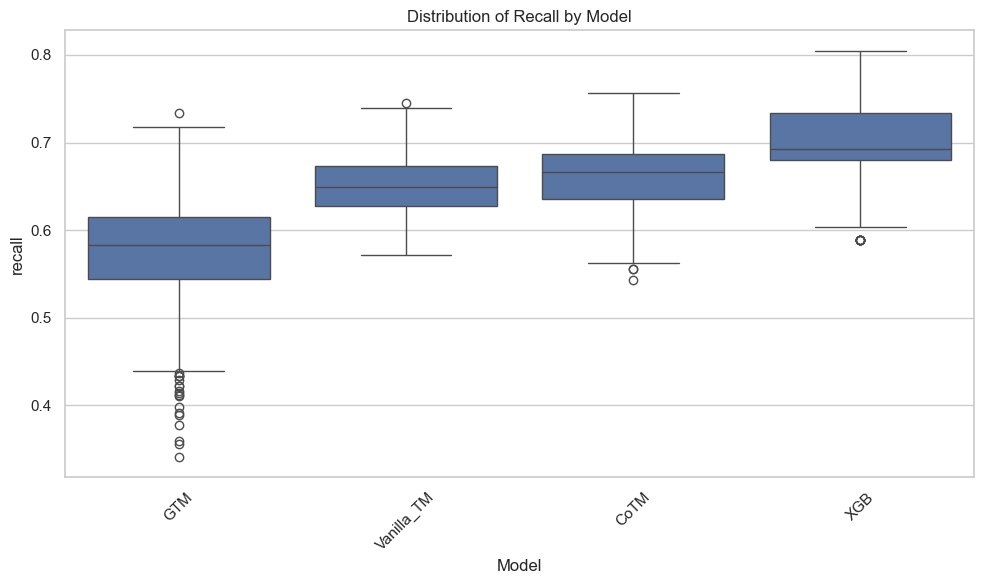

In [103]:
for metric in metrics:
    plt.figure()
    sns.boxplot(data=val_data, x='Model', y=metric)
    plt.title(f'Distribution of {metric.capitalize()} by Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Violin Plots for Metric Distribution
Visualize the distribution and density of metrics across models.

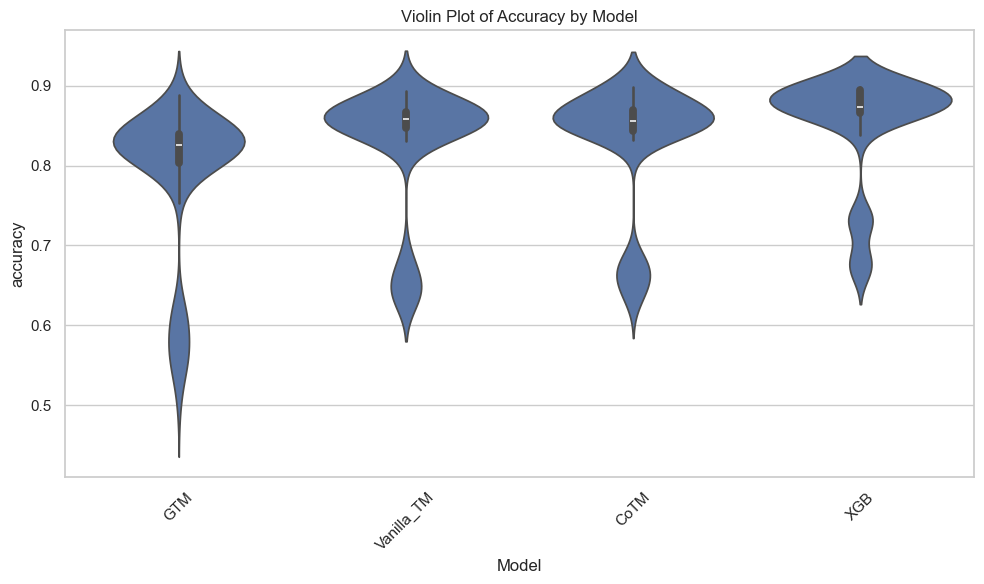

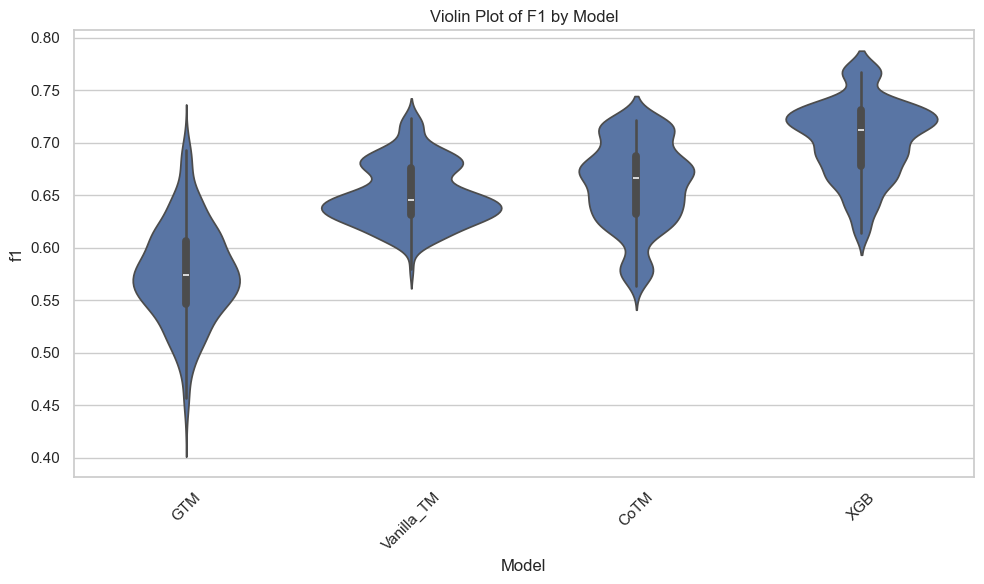

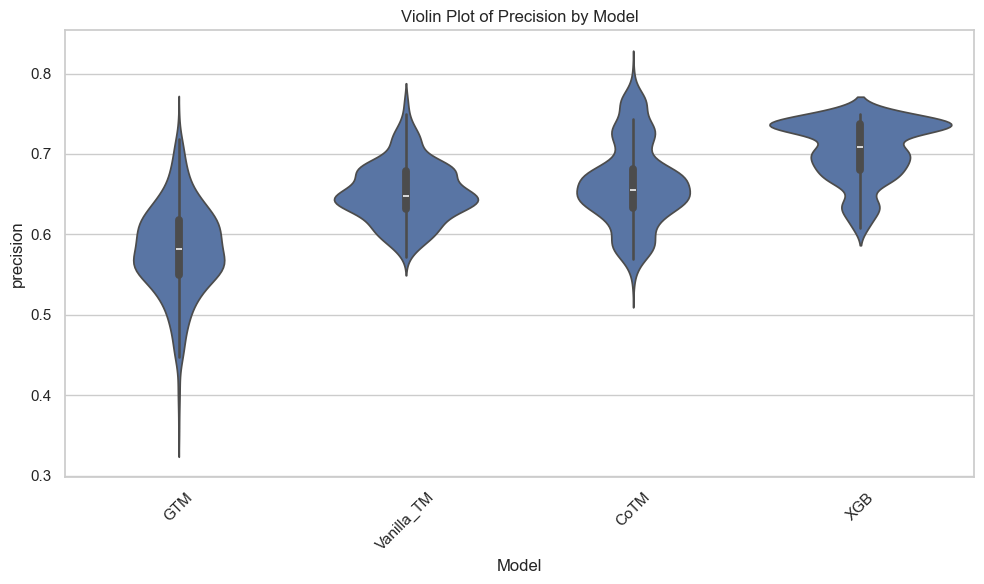

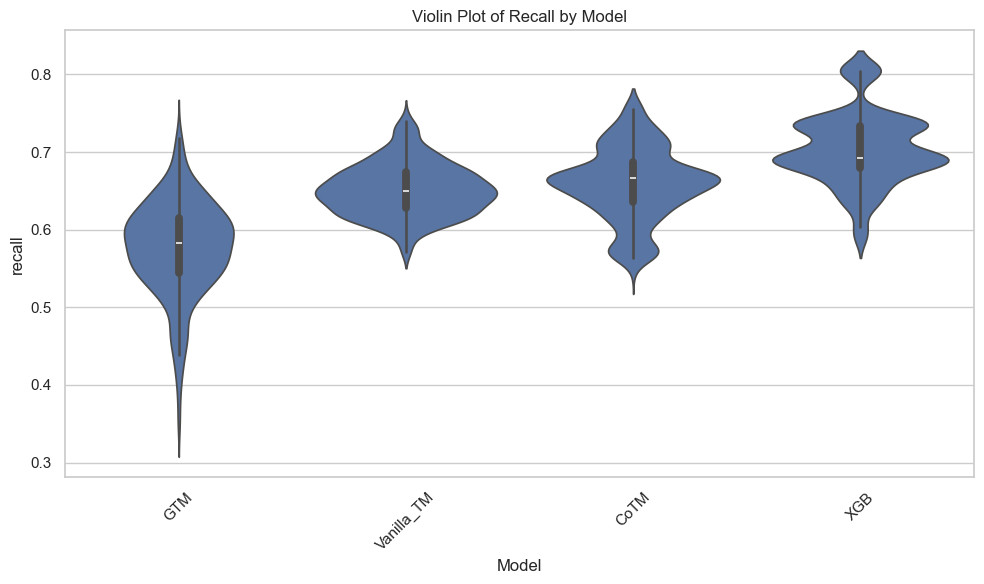

In [104]:
for metric in metrics:
    plt.figure()
    sns.violinplot(data=val_data, x='Model', y=metric)
    plt.title(f'Violin Plot of {metric.capitalize()} by Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Class-wise Performance
Compare per-class F1 scores across models using grouped bar charts.

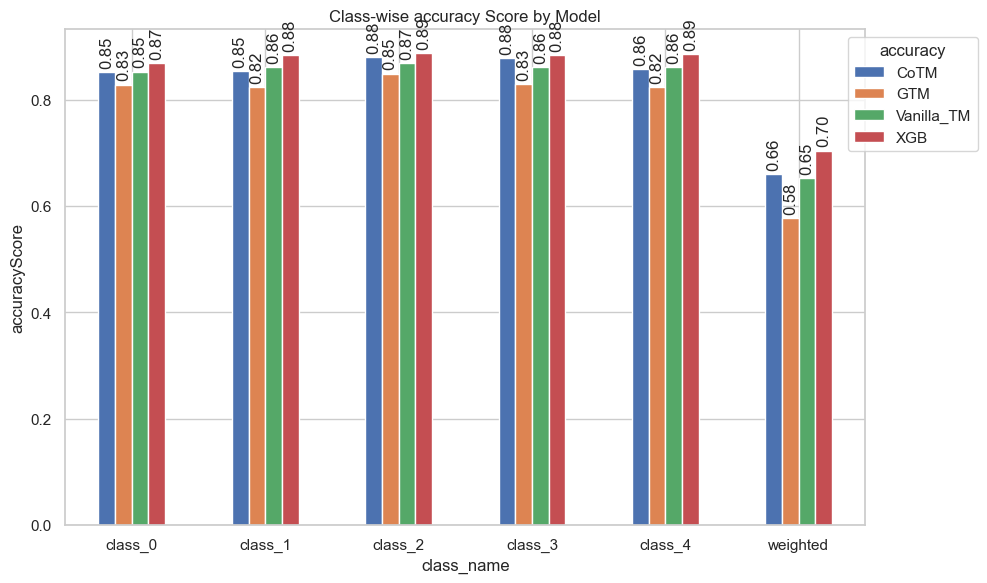

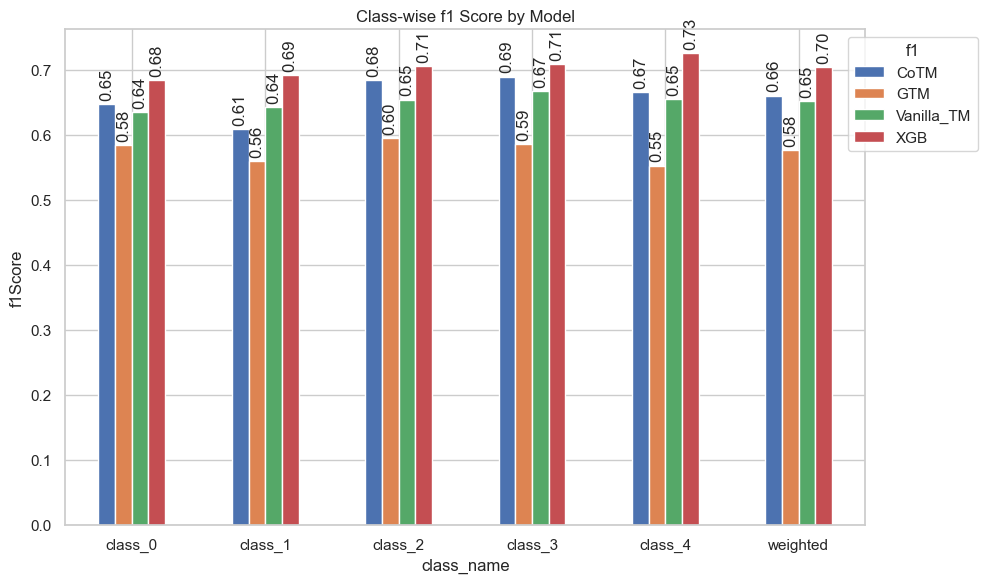

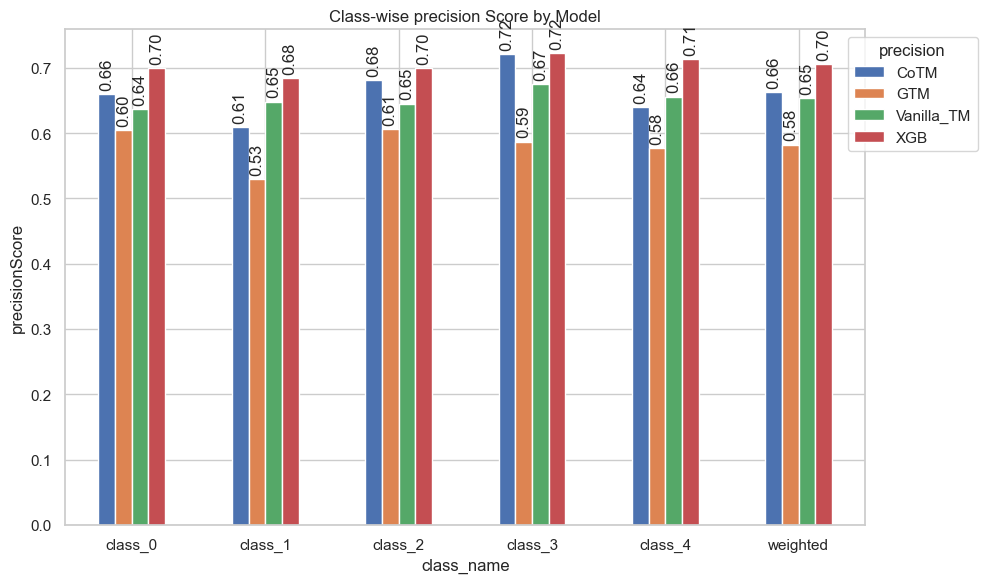

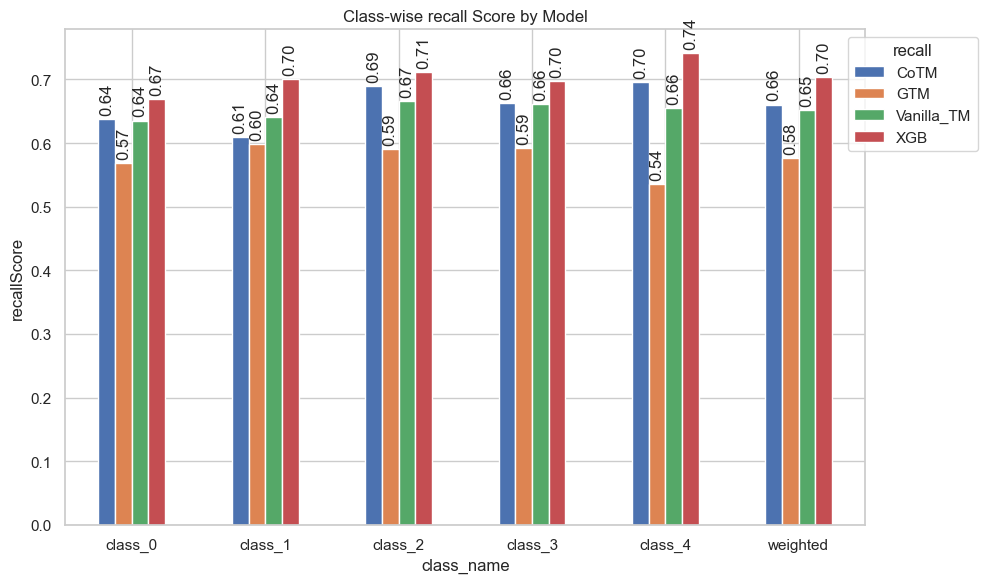

In [105]:
for metric in metrics:
    pivot_classwise = val_data.pivot_table(index='class_name', columns='Model', values=metric, aggfunc='mean')
    ax = pivot_classwise.plot(kind='bar')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, rotation=90)

    plt.title('Class-wise '+metric+' Score by Model')
    plt.ylabel(metric+'Score')
    plt.xticks(rotation=0)
    plt.legend(title=metric, bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()


## Prediction time vs epochs

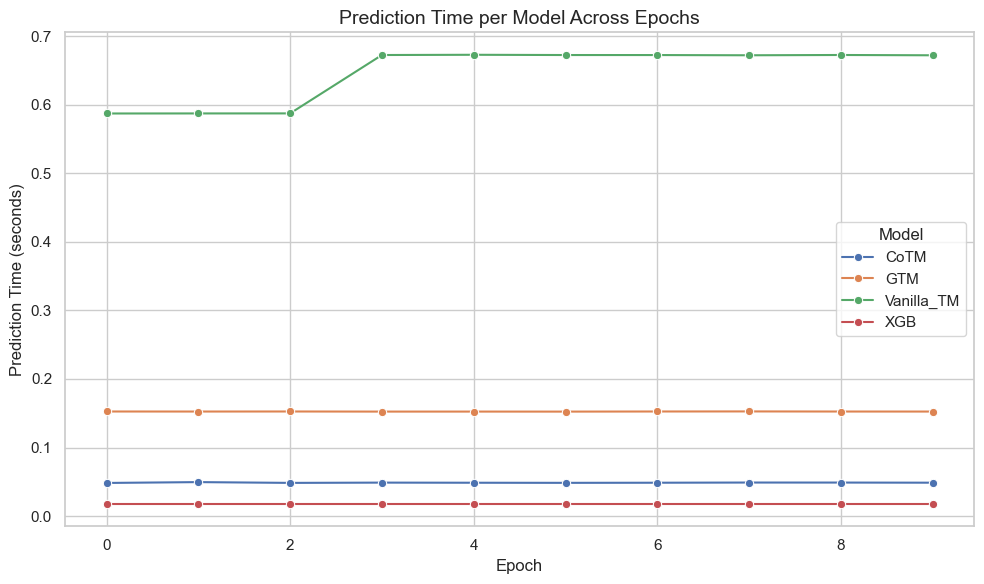

In [106]:

pred_time_data = updated_df.groupby(['Model', 'Epoch'], as_index=False)['pred_time'].mean()

# Set seaborn style
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=pred_time_data, x='Epoch', y='pred_time', hue='Model', marker='o')

# Add labels and title
plt.title('Prediction Time per Model Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Prediction Time (seconds)', fontsize=12)
plt.legend(title='Model')

# Display the plot
plt.tight_layout()
plt.show()


## Peak GPU mem

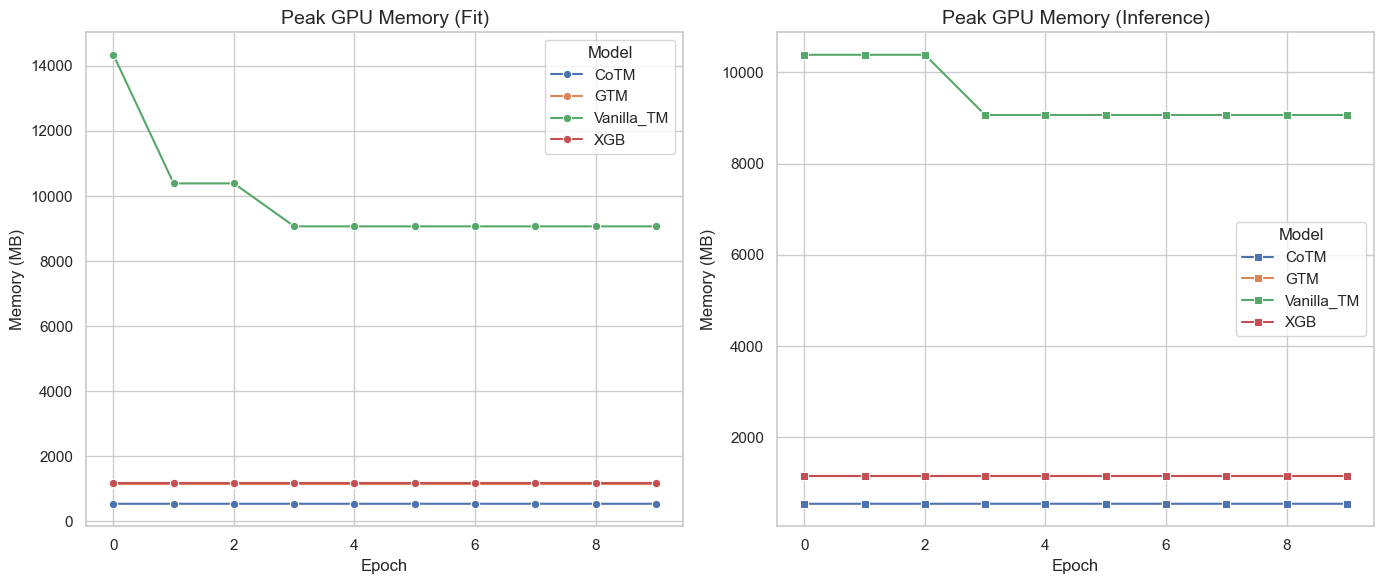

In [108]:

# Group by Model and Epoch to compute average GPU memory usage
gpu_mem_data = updated_df.groupby(['Model', 'Epoch'], as_index=False)[['peak_gpu_mem_fit', 'peak_gpu_mem_infer']].mean()

# Set seaborn style
sns.set(style="whitegrid")

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot 1: Peak GPU Memory during Fit
sns.lineplot(data=gpu_mem_data, x='Epoch', y='peak_gpu_mem_fit', hue='Model', marker='o', ax=axes[0])
axes[0].set_title('Peak GPU Memory (Fit)', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Memory (MB)')
axes[0].legend(title='Model')

# Plot 2: Peak GPU Memory during Inference
sns.lineplot(data=gpu_mem_data, x='Epoch', y='peak_gpu_mem_infer', hue='Model', marker='s', ax=axes[1])
axes[1].set_title('Peak GPU Memory (Inference)', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Memory (MB)')
axes[1].legend(title='Model')

plt.tight_layout()
plt.show()